# Environment Set Up

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# import libraries
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras as keras
from IPython import display
from sklearn import metrics

# Data Load and Preparation

In [ ]:
# read in nba player data
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NBA/shooter_and_defender_per_shot_ranked.csv", sep=",")

# assume if no player_id for defending player then its a generic player which is 443
data.fillna(value={'defender_embedding_index': 443}, inplace=True)
print(data.shape)
data.head(5)

(27321, 14)


,player_id,game_id,event_id,game_clock,shot_clock,x_loc,y_loc,player_id_closest_defender,closest_distance_from_shooter,distance_from_basket,shot_made_flag,recorded_shot_distance,shooter_embedding_index,defender_embedding_index
0,201143,21500001,228,1346.48,10.44,5.90704,38.78493,203083,4.823530,14.088122,1,13,98,255.0
1,202704,21500001,437,2575.29,13.97,19.94944,21.56599,200794,0.885241,17.293812,0,1,233,94.0
2,2594,21500001,477,2721.36,11.19,22.62340,11.06127,203484,2.368097,24.070023,1,20,46,306.0
3,2594,21500001,507,2831.96,17.99,22.47487,13.84307,202704,5.118656,22.444323,0,21,46,233.0
4,203076,21500003,504,2421.86,8.87,24.98951,35.88171,202691,2.629288,24.534673,1,16,248,222.0


In [ ]:
# filter such that shooter has at least 2 shots for train test split
data_grouped = data.groupby(['player_id']).size().reset_index(name='count')
data_grouped = data_grouped[data_grouped['count'] > 2]

data = data.merge(data_grouped, on=['player_id'], how='inner')

print(data.shape)
data.head(5)

(27297, 15)


,player_id,game_id,event_id,game_clock,shot_clock,x_loc,y_loc,player_id_closest_defender,closest_distance_from_shooter,distance_from_basket,shot_made_flag,recorded_shot_distance,shooter_embedding_index,defender_embedding_index,count
0,201143,21500001,228,1346.48,10.44,5.90704,38.78493,203083,4.823530,14.088122,1,13,98,255.0,204
1,201143,21500389,23,155.78,22.63,34.75976,28.39524,101161,7.724437,31.940727,1,1,98,79.0,204
2,201143,21500117,128,684.09,11.85,28.63058,34.59180,201962,11.755243,27.366572,1,24,98,172.0,204
3,201143,21500639,9,98.68,14.22,17.88401,27.73281,203943,5.145146,15.132812,0,9,98,364.0,204
4,201143,21500117,185,1071.38,12.05,22.85049,28.88055,201583,8.837067,20.226236,1,18,98,139.0,204


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


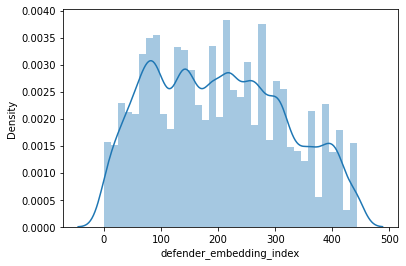

In [ ]:
# Auditing via distribution of filtered plays across defenders
sns.distplot(data.defender_embedding_index);

# Model Architecture

In [ ]:
# Model parameters
terms_embedding_column = tf.feature_column.embedding_column('player_id', dimension=5)
feature_columns = ['shooter_embedding_index', 'x_loc', 'y_loc','recorded_shot_distance', 'closest_distance_from_shooter', 'defender_embedding_index'] #'distance_from_basket',

# + 1 for players without any shot record that are defenders
player_size = 443 + 1
player_size

444

In [ ]:
# Define model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, LeakyReLU, add, Concatenate

# inputs
input1 = keras.layers.Input(shape=(1,), name='shooter_index')
input2 = Input(shape=(4,))
input3 = Input(shape=(1,), name='defender_index')
input4 = Input(shape=(1,))
input5 = Input(shape=(1,)) 

# offensive player embedding
off_emb = Embedding(input_dim=player_size, output_dim=5,input_length = 1, name='embedding_offense')(input1)
off_emb = Flatten()(off_emb)

# defensive player embedding
def_emb = Embedding(input_dim=player_size, output_dim=5,input_length = 1, name='embedding_defense')(input3)
def_emb = Flatten()(def_emb)

# average embedding
off_emb_constant = Dense(5, activation=LeakyReLU(alpha=0.1), name='average_off')(input5)
def_emb_constant = Dense(5, activation=LeakyReLU(alpha=0.1), name='average_def')(input5)

# add embedding
off_emb_add = add([off_emb_constant, off_emb], name='add_off') 
def_emb_add = add([def_emb_constant, def_emb], name='add_def')

# layer 1
# concatenate offensive 
off_concat = Concatenate(axis=1, name='concat_offense')([off_emb_add, input2]) 
# concatenate defensive
def_concat = Concatenate(axis=1, name='concat_defense')([def_emb_add, input4]) 

# layer 2
off_relu = Dense(20, activation='relu')(off_concat)
def_relu = Dense(20, activation='relu')(def_concat)

# layer 3
full_concat = Concatenate(axis=1)([off_relu, def_relu])

# fully connected nn
w = Dense(40, activation=LeakyReLU(alpha=0.1))(full_concat)
x = Dense(20, activation=LeakyReLU(alpha=0.1))(w)
y = Dense(20, activation=LeakyReLU(alpha=0.1))(x)
z = Dense(5, activation=LeakyReLU(alpha=0.1))(y)
output = Dense(1, activation='sigmoid')(z)

model = tf.keras.Model(inputs=[input1, input2, input3, input4, input5], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shooter_index (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
defender_index (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_offense (Embedding)   (None, 1, 5)         2220        shooter_index[0][0]              
____________________________________________________________________________________________

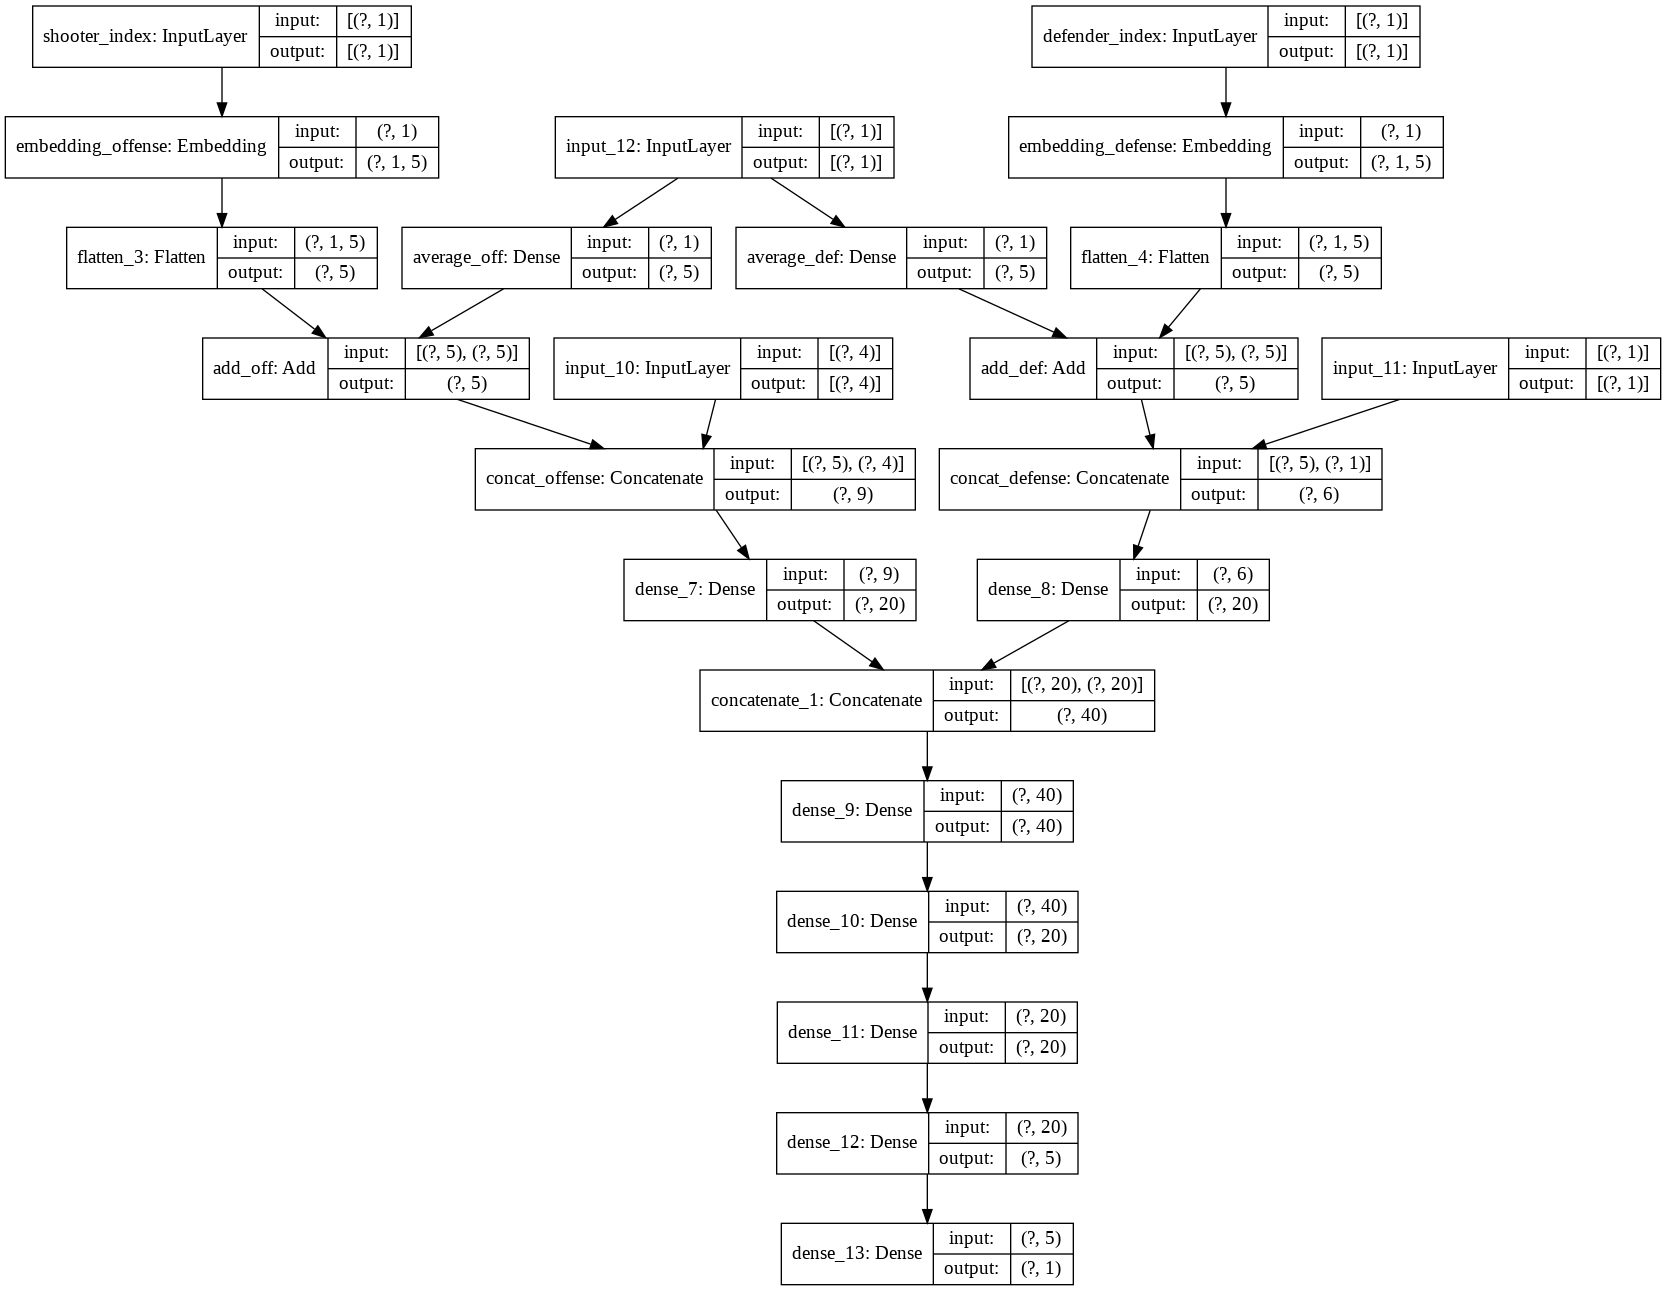

In [ ]:
# graphical illustration of model architecutre
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

In [ ]:
# auditing via visualization of first few rows of data
data.head()


,player_id,game_id,event_id,game_clock,shot_clock,x_loc,y_loc,player_id_closest_defender,closest_distance_from_shooter,distance_from_basket,shot_made_flag,recorded_shot_distance,shooter_embedding_index,defender_embedding_index,count
0,201143,21500001,228,1346.48,10.44,5.90704,38.78493,203083,4.823530,14.088122,1,13,98,255.0,204
1,201143,21500389,23,155.78,22.63,34.75976,28.39524,101161,7.724437,31.940727,1,1,98,79.0,204
2,201143,21500117,128,684.09,11.85,28.63058,34.59180,201962,11.755243,27.366572,1,24,98,172.0,204
3,201143,21500639,9,98.68,14.22,17.88401,27.73281,203943,5.145146,15.132812,0,9,98,364.0,204
4,201143,21500117,185,1071.38,12.05,22.85049,28.88055,201583,8.837067,20.226236,1,18,98,139.0,204


In [ ]:
from sklearn.model_selection import train_test_split

# prep train data
X_shooter = data[['shooter_embedding_index']]
X_off_rest = data[['x_loc', 'y_loc', 'recorded_shot_distance', 'closest_distance_from_shooter']]
X_defender = data[['defender_embedding_index']]
X_defender_rest = data[['closest_distance_from_shooter']]
X_ones = pd.DataFrame(np.ones(data.shape[0]))
y = data[['shot_made_flag']]

# auditing of data shape
print(X_shooter.shape)
print(X_off_rest.shape)
print(X_defender.shape)
print(X_defender_rest.shape)
print(X_ones.shape)
print(y.shape)

(27297, 1)
(27297, 4)
(27297, 1)
(27297, 1)
(27297, 1)
(27297, 1)


# Model Training

In [ ]:
# model training
history = model.fit([X_shooter, X_off_rest, X_defender, X_defender_rest, X_ones],
                    y,
                    epochs=2000,
                    batch_size=2**15,
                    verbose=1)

Train on 27297 samples
Epoch 1/2000
27297/27297 [==============================] - 0s 6us/sample - loss: 0.7726 - acc: 0.4446 - auc_2: 0.4860
Epoch 2/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.7255 - acc: 0.4781 - auc_2: 0.4901
Epoch 3/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.6963 - acc: 0.5145 - auc_2: 0.5102
Epoch 4/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.6840 - acc: 0.5515 - auc_2: 0.5393
Epoch 5/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.6816 - acc: 0.5631 - auc_2: 0.5596
Epoch 6/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.6822 - acc: 0.5632 - auc_2: 0.5667
Epoch 7/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.6830 - acc: 0.5628 - auc_2: 0.5722
Epoch 8/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.6838 - acc: 0.5627 - auc_2: 0.5758
Epoch 9/2000
27297/27297 

# Extract Embedding Weights for Visualization 

In [ ]:
# extract offensive player embeddings
offensive_weights = model.get_layer('embedding_offense').get_weights()[0]
print(offensive_weights.shape)

# extract defensive player embeddings
defensive_weights = model.get_layer('embedding_defense').get_weights()[0]
print(defensive_weights.shape)

(444, 5)
(444, 5)


In [ ]:
# filter to only players who have more than 20 shots
filtered_data = data.groupby(['player_id', 'shooter_embedding_index']).size().reset_index(name='count')
filtered_data = filtered_data[filtered_data['count'] > 20]

filtered_offensive_weights = []
filtered_offensive_players = filtered_data['shooter_embedding_index'].tolist()

for idx, weight in enumerate(offensive_weights):
  if idx in filtered_offensive_players:
    filtered_offensive_weights.append(weight)
    
# filter to only players who have more than 20 defenses
filtered_data = data.groupby(['defender_embedding_index']).size().reset_index(name='count')
filtered_data = filtered_data[filtered_data['count'] > 20]

filtered_defensive_weights = []
filtered_defensive_players = filtered_data['defender_embedding_index'].tolist()

for idx, weight in enumerate(defensive_weights):
  if idx in filtered_defensive_players:
    filtered_defensive_weights.append(weight)

# auditing
print(len(filtered_offensive_weights))
print(len(filtered_defensive_weights))
print(len(filtered_defensive_players))

306
324
324


In [ ]:
# filter player metadata to only players with more than 20 shots
player_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NBA/player_aggregates.csv", sep=",")
shooter_player_data = player_data[player_data['rank'].isin(filtered_offensive_players)]
defender_player_data = player_data[player_data['rank'].isin(filtered_defensive_players)]

In [ ]:
import io

# save shooter and defender player embeddings as vecs.tsv
out_vs = io.open('/content/drive/My Drive/Colab Notebooks/NBA/vecs_shooter.tsv', 'w', encoding='utf-8')
for ind, vector in enumerate(filtered_offensive_weights):
  out_vs.write('\t'.join([str(x) for x in vector]) + "\n")
out_vs.close()

out_vd = io.open('/content/drive/My Drive/Colab Notebooks/NBA/vecs_defender.tsv', 'w', encoding='utf-8')
for ind, vector in enumerate(filtered_defensive_weights):
  out_vd.write('\t'.join([str(x) for x in vector]) + "\n")
out_vd.close()


# save player metadata as meta.tsv
shooter_player_data.to_csv('/content/drive/My Drive/Colab Notebooks/NBA/meta_shooter.tsv',sep='\t')
defender_player_data.to_csv('/content/drive/My Drive/Colab Notebooks/NBA/meta_defender.tsv',sep='\t')


In [ ]:
# download player embeddings
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('/content/drive/My Drive/Colab Notebooks/NBA/vecs_shooter.tsv')
  files.download('/content/drive/My Drive/Colab Notebooks/NBA/meta_shooter.tsv')
  files.download('/content/drive/My Drive/Colab Notebooks/NBA/vecs_defender.tsv')
  files.download('/content/drive/My Drive/Colab Notebooks/NBA/meta_defender.tsv')

In [ ]:
# save model in google drive
model.save('/content/drive/My Drive/Colab Notebooks/NBA/offensive_defensive_model_v1.h5') 

# Shot Chart Exhibits

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, LeakyReLU, add, Concatenate

# load original model
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/NBA/offensive_defensive_model_best.h5',
                                   custom_objects={'LeakyReLU': LeakyReLU(alpha=0.1)})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Define new model that enables estimates for average player performance
# by removing embedding layers and keeping all downstream layers

# grab all layers from prior model to insert/replace in new model
layers = [l for l in model.layers]

# inputs
input2 = Input(shape=(4,))
offensive_embedding = Input(shape=(5,), name='offensive_embedding')
input4 = Input(shape=(1,))
defensive_embedding = Input(shape=(5,), name='defensive_embedding')
input5 = Input(shape=(1,))

# constant embeddings
off_emb_constant = model.get_layer('avg_off_player')(input5) 
def_emb_constant = model.get_layer('avg_def_player')(input5) 

# add embeddings
off_emb_add = model.get_layer('add_offensive_embedding')([off_emb_constant, offensive_embedding]) 
def_emb_add = model.get_layer('add_defensive_embedding')([def_emb_constant, defensive_embedding]) 

# concatenate
off_concat = model.get_layer('concatenate_offensive')([off_emb_add, input2]) 
def_concat = model.get_layer('concatenate_defensive')([def_emb_add, input4]) 

# relu and concat
off_relu = layers[-8](off_concat)
def_relu = layers[-7](def_concat)
full_concat = layers[-6]([off_relu, def_relu])

# fully connected layers
w = layers[-5](full_concat)
x = layers[-4](w)
y = layers[-3](x)
z = layers[-2](y)
output = layers[-1](z)

new_model = tf.keras.Model(inputs=[input2, input4, offensive_embedding, defensive_embedding, input5], outputs=output)

new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
avg_off_player (Dense)          (None, 5)            10          input_3[0][0]                    
__________________________________________________________________________________________________
offensive_embedding (InputLayer [(None, 5)]          0                                            
__________________________________________________________________________________________________
avg_def_player (Dense)          (None, 5)            10          input_3[0][0]                    
______________________________________________________________________________________________

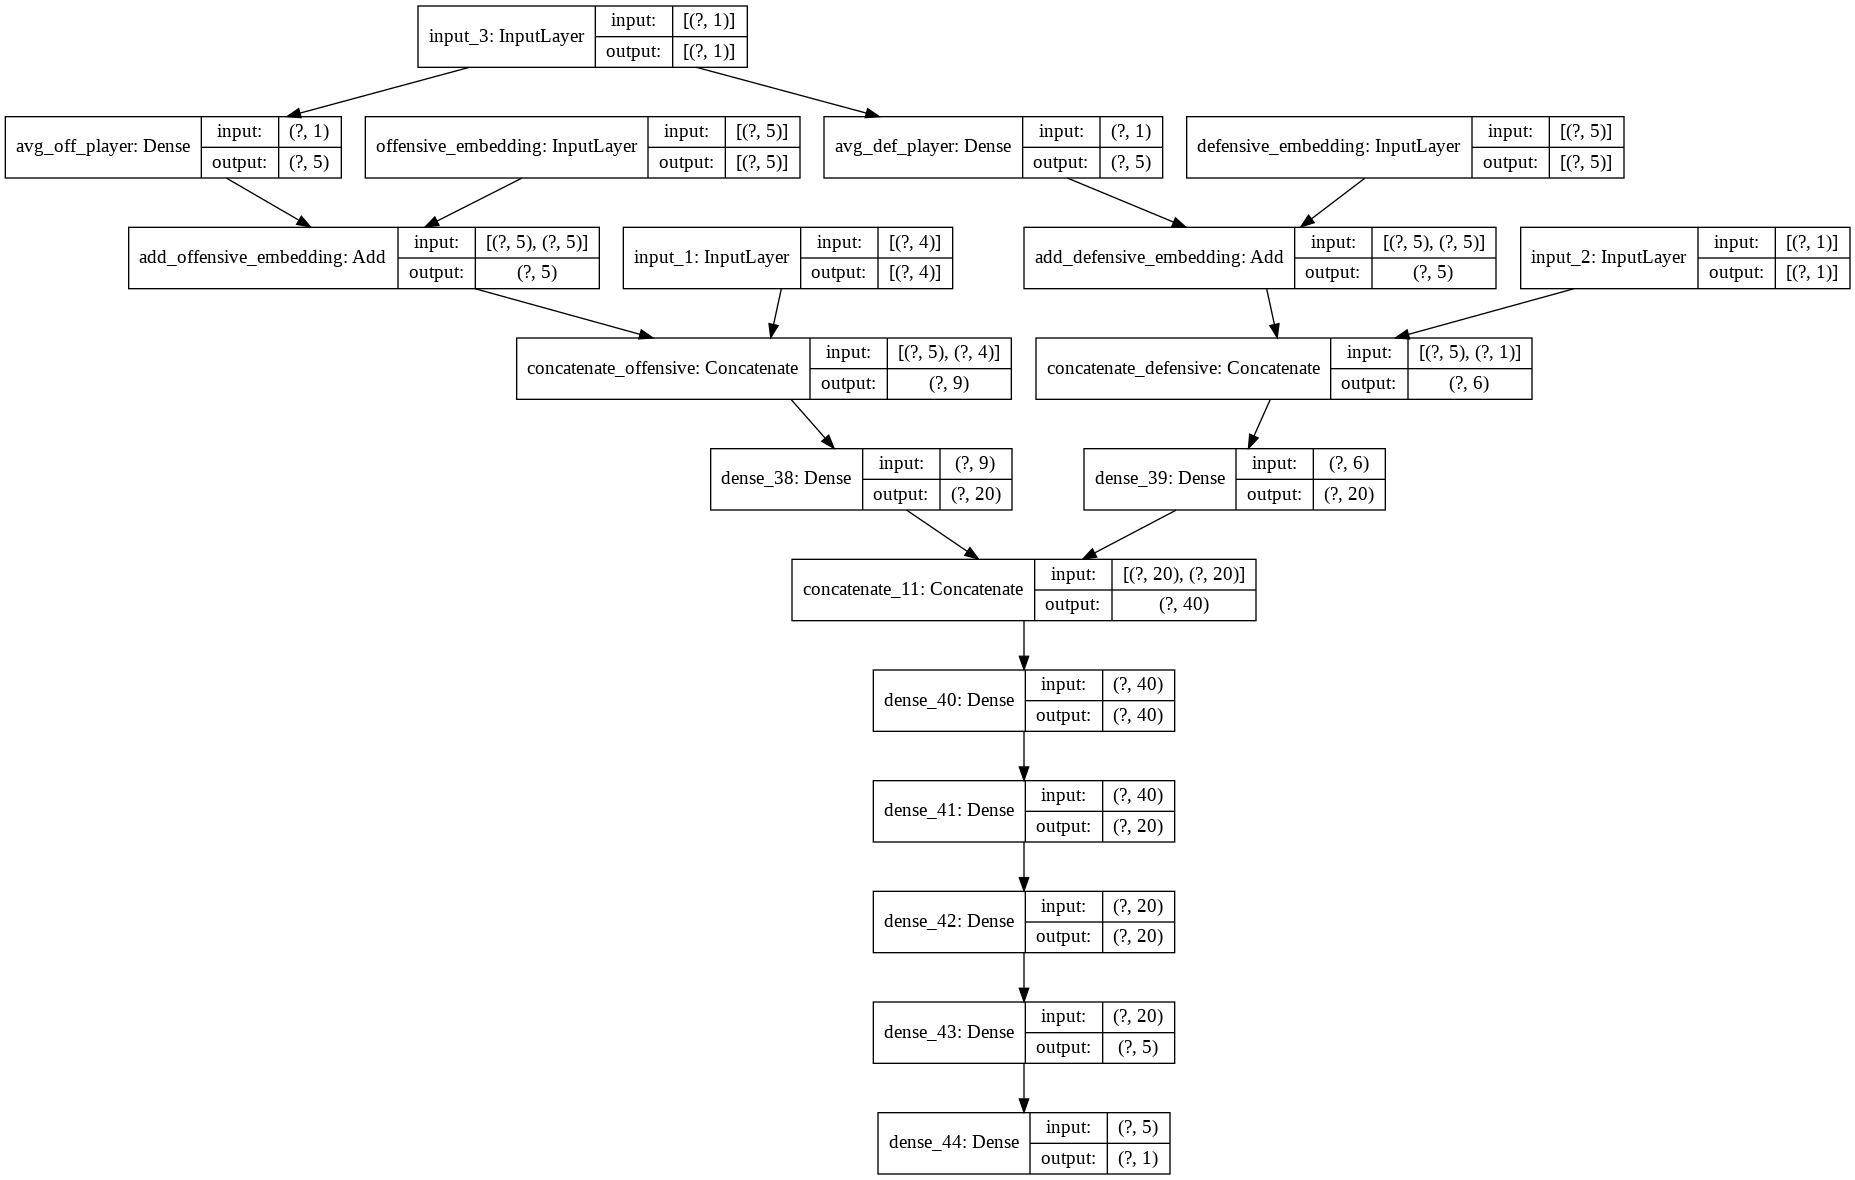

In [ ]:
# graphical illustration of model architecutre
from tensorflow.keras.utils import plot_model
plot_model(new_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras import backend as K

# grab unique player indexes and names
player_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NBA/player_aggregates.csv", sep=",")

# grab offensive and defensive weights
offensive_weights = model.get_layer('offensive_embedding').get_weights()[0]
defensive_weights = model.get_layer('defensive_embedding').get_weights()[0]

# determine average player embeddings
avg_off_player = model.get_layer('avg_off_player')
avg_off_player_function = K.function(avg_off_player.input, avg_off_player.output)
average_offensive_weights = avg_off_player_function(pd.DataFrame([1]))
avg_def_player = model.get_layer('avg_def_player')
avg_def_player_function = K.function(avg_def_player.input, avg_def_player.output)
average_defensive_weights = avg_def_player_function(pd.DataFrame([1]))

# dictionaries to map player indexes and names to offensive / defensive embeddings
id_offensive_embedding_dict = dict(zip(player_data['rank'], offensive_weights))
name_offensive_embedding_dict = dict(zip(player_data['PLAYER_NAME'], offensive_weights))
id_defensive_embedding_dict = dict(zip(player_data['rank'], defensive_weights))
name_defensive_embedding_dict = dict(zip(player_data['PLAYER_NAME'], defensive_weights))

Using TensorFlow backend.


In [ ]:
import math

def shot_chart(distance_between_shooter_defender, shooter_embedding, defender_embedding):
  """
  Generate shot chart probabilities in the half court based on offensive and defensive Player Embiidings

  Parameters
  ----------
  distance_between_shooter_defender: float illustrating distance between the shooter and defender
    in feet at the time of the shot
  shooter_embedding: Player Embiiding of the shooter
  defender_embedding: Player Embiiding of the defender
  
  Returns
  -------
  List of 250 shot chart probabilities across the half court from the upper left to the bottom right
    of the half court

  """

  shot_chart = []

  # for simplicity, divide a 50 feet by 50 feet half court into 250 sections and predict shot probability in each section 
  for i in range(50):
    for j in range(50):
      # parameters for offensive shot outside of shooter embedding
      X_train_off_rest_2 = np.array([i, j, math.sqrt((i-3)**2 + (j-25)**2), distance_between_shooter_defender]).reshape(1,-1)
      # parameters for defender outside of defender embedding
      X_train_defender_rest_2 = np.array([distance_between_shooter_defender]).reshape(1,-1)
      # model prediction of shot probability
      y = new_model.predict([X_train_off_rest_2, X_train_defender_rest_2, shooter_embedding.reshape(1,-1), defender_embedding.reshape(1,-1), np.array([1])])
      # append to shot chart list
      shot_chart.append(y.reshape(-1)[0])

  return shot_chart

In [ ]:
# generate 5 shot charts for various situations illustrating the power of embeddings
average_offensive_defensive_chart = shot_chart(3, average_offensive_weights, average_defensive_weights)
steph_curry_shot_chart = shot_chart(3, name_offensive_embedding_dict["Stephen Curry"], average_defensive_weights)
lebron_james_shot_chart = shot_chart(3, name_offensive_embedding_dict["LeBron James"], average_defensive_weights)
draymond_green_defense_chart = shot_chart(3, average_offensive_weights, name_defensive_embedding_dict["Draymond Green"])
lebron_vs_draymond_shot_chart = shot_chart(3, name_offensive_embedding_dict["LeBron James"], name_defensive_embedding_dict["Draymond Green"])

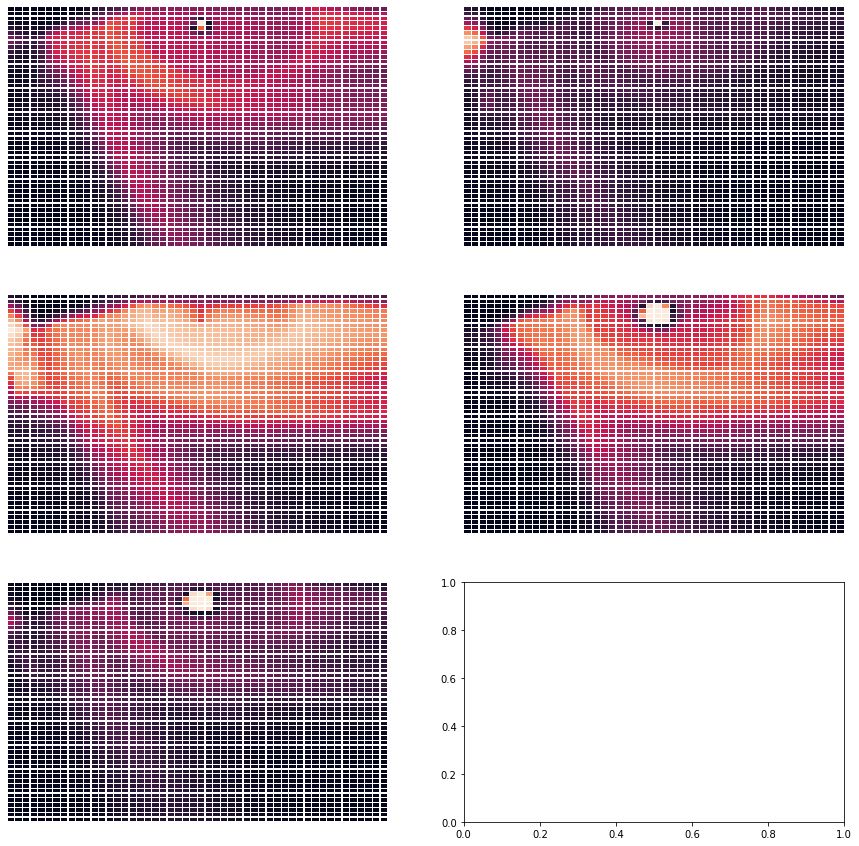

In [ ]:
# plot resulting shot charts
import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(3,2, figsize=(15,15))

# helper function for plotting charts
def plot_heatmap(situational_shot_chart, axis):
  sns.heatmap(np.array(situational_shot_chart).reshape(50,50), linewidth=0.25, ax=axis,
            xticklabels=False, yticklabels=False, cbar=False)

# plot all chart matchups
charts = [[average_offensive_defensive_chart, ax[0,0]],
          [draymond_green_defense_chart, ax[0,1]],
          [steph_curry_shot_chart, ax[1,0]],
          [lebron_james_shot_chart, ax[1,1]],
          [lebron_vs_draymond_shot_chart, ax[2,0]]
         ]
for chart in charts:
  plot_heatmap(chart[0], chart[1])

plt.show()

# Strategic Matchups

In [ ]:
# mapping from player number in data to name
dict_rank_to_name = dict(zip(player_data['rank'], player_data['PLAYER_NAME']))

# filter to top ~50 defenders in terms of representation
data_filtered_defenders = data.groupby(['defender_embedding_index']).size().reset_index(name='count')
filtered_defenders = data_filtered_defenders[data_filtered_defenders['count'] > 125].defender_embedding_index.to_list()

In [ ]:
# strategic matchups for LeBron
lebron_result = {}

# -1 for average defender
lebron_result[-1] = shot_chart(3, name_offensive_embedding_dict["LeBron James"], average_defensive_weights)

# calculate situtational shot chart of LeBron against all defenders
for i in filtered_defenders:
  lebron_result[i] = shot_chart(3, name_offensive_embedding_dict["LeBron James"], id_defensive_embedding_dict[i])
  print(i)

15.0
30.0
46.0
49.0
52.0
63.0
64.0
65.0
79.0
80.0
82.0
94.0
97.0
98.0
110.0
112.0
124.0
133.0
139.0
142.0
143.0
147.0
157.0
166.0
182.0
185.0
186.0
200.0
211.0
216.0
221.0
222.0
237.0
246.0
248.0
251.0
253.0
258.0
259.0
267.0
271.0
272.0
273.0
283.0
295.0
298.0
299.0
305.0
308.0
311.0
317.0
335.0
342.0
382.0
388.0
409.0
443.0


In [ ]:
# saving and loading matchup files
import pickle

with open('/content/drive/My Drive/Colab Notebooks/NBA/lebron_matchups.pickle', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Colab Notebooks/NBA/lebron_matchups.pickle', 'rb') as handle:
    result = pickle.load(handle)

In [ ]:
# ranking of results
result = {k:v for k,v in lebron_result.items() if k in filtered_defenders or k == -1}
result_comparison = {k: np.average(np.asarray(v) - np.asarray(result[-1])) for k,v in result.items()}
top_10_indices = sorted(result_comparison, key=result_comparison.get, reverse=False)[:10]
{dict_rank_to_name[k]:v for k,v in result_comparison.items() if k in top_10_indices}

{'Andre Roberson': -0.22779815,
 'Andrew Bogut': -0.210048,
 'Anthony Davis': -0.23045447,
 'Avery Bradley': -0.21578003,
 'DeAndre Jordan': -0.21560559,
 'Draymond Green': -0.19474411,
 'Kevin Durant': -0.1903174,
 'Pau Gasol': -0.2229749,
 'Serge Ibaka': -0.21986015,
 'Steven Adams': -0.19727261}